In [1]:
# Import libraries for the assignment

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.neural_network import MLPClassifier


In [2]:
# Load dataset

cvd_data = pd.read_csv('./heart_failure_clinical_records_dataset.csv')
cvd_data

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


In [3]:
cvd_data.isna().sum() # checking for missing values

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

In [4]:
cvd_data.dtypes # checking variable types for anything unexpected

age                         float64
anaemia                       int64
creatinine_phosphokinase      int64
diabetes                      int64
ejection_fraction             int64
high_blood_pressure           int64
platelets                   float64
serum_creatinine            float64
serum_sodium                  int64
sex                           int64
smoking                       int64
time                          int64
DEATH_EVENT                   int64
dtype: object

In [5]:
cvd_data['DEATH_EVENT'].value_counts() # seeing how skewed target values may be

0    203
1     96
Name: DEATH_EVENT, dtype: int64

In [6]:
# Separate target values
X = cvd_data.iloc[:, :-1]
y = cvd_data.loc[:, 'DEATH_EVENT']

# Create data split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, stratify=y) #stratify bc saw target data skewed

In [7]:
print('Labels count in y:', np.bincount(y))
print('Labels count in y_train', np.bincount(y_train))
print('Labels count in y_test',np.bincount(y_test))

Labels count in y: [203  96]
Labels count in y_train [162  77]
Labels count in y_test [41 19]


# KNN

In [8]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)


In [9]:
knn = KNeighborsClassifier(metric='minkowski')

search_space = {
    'n_neighbors' : [3, 5, 8, 10, 12, 15],
    'p' : [1, 2]
}

GS = GridSearchCV(estimator = knn,
                 param_grid = search_space,
                 scoring = 'accuracy',
                 refit = True,
                 cv = 5,
                 n_jobs = -1,
                 verbose = 3)

gs = GS.fit(X_train_std, y_train)

print(gs.best_score_)
print(gs.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
0.7408687943262412
{'n_neighbors': 15, 'p': 1}


In [10]:
clf = gs.best_estimator_

y_pred = clf.predict(X_test_std)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.98      0.83        41
           1       0.80      0.21      0.33        19

    accuracy                           0.73        60
   macro avg       0.76      0.59      0.58        60
weighted avg       0.75      0.73      0.68        60



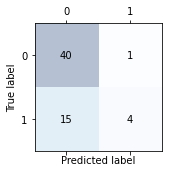

In [11]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.show()

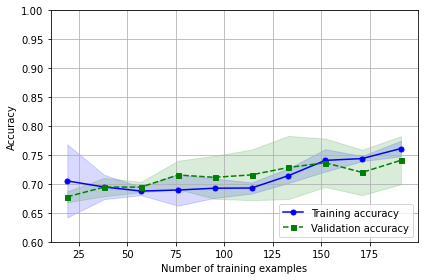

In [12]:
train_sizes, train_scores, test_scores =\
                learning_curve(estimator=clf,
                               X=X_train_std,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=5,
                               n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.6, 1.0])
plt.tight_layout()

plt.show()

## SVM

In [13]:
pipe_svc = make_pipeline(StandardScaler(),
                         SVC(random_state=1))

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

param_grid = {'svc__C': param_range, 
              'svc__kernel': ['linear', 'rbf'],
              'svc__gamma': param_range}

GS = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  refit=True,
                  cv=5,
                  n_jobs=-1)

gs = GS.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.8368794326241135
{'svc__C': 0.1, 'svc__gamma': 0.0001, 'svc__kernel': 'linear'}


              precision    recall  f1-score   support

           0       0.86      0.88      0.87        41
           1       0.72      0.68      0.70        19

    accuracy                           0.82        60
   macro avg       0.79      0.78      0.79        60
weighted avg       0.81      0.82      0.82        60



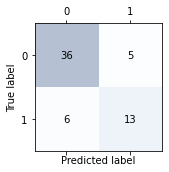

In [14]:
clf = gs.best_estimator_

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.show()

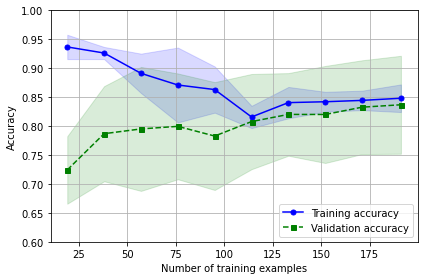

In [15]:
train_sizes, train_scores, test_scores =\
                learning_curve(estimator=clf,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=5,
                               n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.6, 1.0])
plt.tight_layout()

plt.show()

## Decision Tree

In [22]:
search_space = {'max_depth': [3, 4, 5, 6],
               'criterion' : ['gini', 'entropy']}

GS = GridSearchCV(estimator=DecisionTreeClassifier(), 
                  param_grid=search_space, 
                  scoring='accuracy', 
                  refit=True,
                  cv=10,
                  n_jobs=-1)

gs = GS.fit(X_train_std, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.803623188405797
{'criterion': 'entropy', 'max_depth': 6}


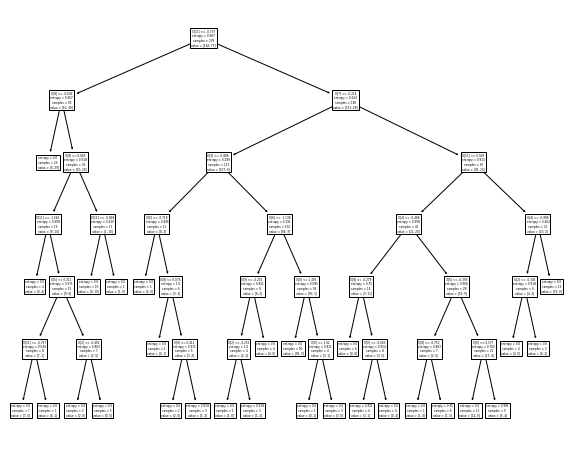

In [23]:
plt.figure(figsize=(10,8))
plot_tree(gs.best_estimator_)
plt.show()

              precision    recall  f1-score   support

           0       0.92      0.85      0.89        41
           1       0.73      0.84      0.78        19

    accuracy                           0.85        60
   macro avg       0.82      0.85      0.83        60
weighted avg       0.86      0.85      0.85        60



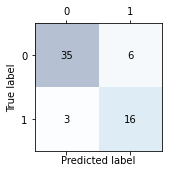

In [24]:
clf = gs.best_estimator_

y_pred = clf.predict(X_test_std)
print(classification_report(y_test, y_pred))

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.show()

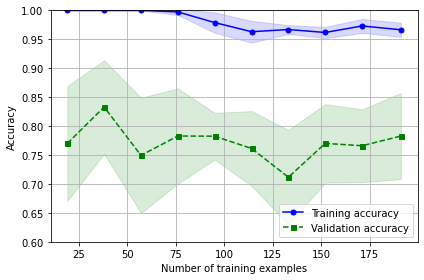

In [25]:
train_sizes, train_scores, test_scores =\
                learning_curve(estimator=clf,
                               X=X_train_std,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=5,
                               n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.6, 1.0])
plt.tight_layout()

plt.show()

# Boosted

In [26]:
boost = GradientBoostingClassifier()

search_space = {'n_estimators': [50, 100, 150, 200]}

GS = GridSearchCV(estimator=boost, 
                  param_grid=search_space, 
                  scoring='accuracy', 
                  refit=True,
                  cv=10,
                  n_jobs=-1)

gs = GS.fit(X_train_std, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.8244565217391303
{'n_estimators': 50}


              precision    recall  f1-score   support

           0       0.95      0.85      0.90        41
           1       0.74      0.89      0.81        19

    accuracy                           0.87        60
   macro avg       0.84      0.87      0.85        60
weighted avg       0.88      0.87      0.87        60



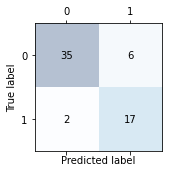

In [27]:
clf = gs.best_estimator_

y_pred = clf.predict(X_test_std)
print(classification_report(y_test, y_pred))

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.show()

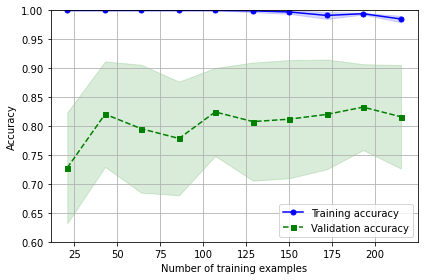

In [28]:
train_sizes, train_scores, test_scores =\
                learning_curve(estimator=clf,
                               X=X_train_std,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.6, 1.0])
plt.tight_layout()

plt.show()

# Neural Network

In [29]:
search_space = {'hidden_layer_sizes' : [[5,5,5],[10,10,10],[5,5,5,5],[10,10,10,10]],
               'max_iter' : [200, 500, 700]}

GS = GridSearchCV(estimator=MLPClassifier(), 
                  param_grid=search_space, 
                  scoring='accuracy', 
                  refit=True,
                  cv=5,
                  n_jobs=-1)

gs = GS.fit(X_train_std, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.7909574468085105
{'hidden_layer_sizes': [10, 10, 10], 'max_iter': 200}


C:\Users\tclav\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.84      0.90      0.87        41
           1       0.75      0.63      0.69        19

    accuracy                           0.82        60
   macro avg       0.80      0.77      0.78        60
weighted avg       0.81      0.82      0.81        60



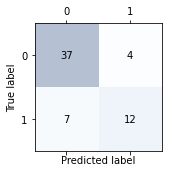

In [30]:
clf = gs.best_estimator_

y_pred = clf.predict(X_test_std)
print(classification_report(y_test, y_pred))

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.show()

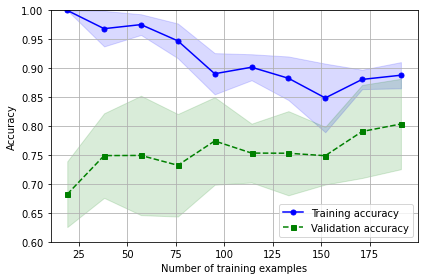

In [31]:
train_sizes, train_scores, test_scores =\
                learning_curve(estimator=clf,
                               X=X_train_std,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=5,
                               n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.6, 1.0])
plt.tight_layout()

plt.show()